In [43]:
import polars as pl
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os

In [44]:
DATA_PATH = "data/20240704.csv"
META_PATH = "data/meta_20240704.csv"
IT_PATH = "data/IT"
IMAGE_PATH = "images"
DELAY_TIME = 50.08 # ns(+)

In [45]:
if not os.path.exists(IT_PATH):
    os.makedirs(IT_PATH)
if not os.path.exists(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)

メタデータの取得

In [46]:
meta = pl.read_csv(META_PATH, has_header=False)
meta

column_1,column_2
str,f64
"""Sample Interval""",1.6000e-10
"""Record Length""",50000.0
"""Zero Index""",1250.0
"""yOffset""",-0.06


In [47]:
record_len = int(meta.filter(pl.col("column_1") == "Record Length")[0,1])
record_len

50000

実データの分割

In [48]:
df_all = pl.read_csv(DATA_PATH)
df_all

TIME,CH1
f64,f64
-0.000036,0.0006
-0.000036,-0.0006
-0.000036,0.0
-0.000036,0.0
-0.000036,0.0
…,…
0.000004,0.0
0.000004,0.0
0.000004,0.0006


In [49]:
fastframe_count = df_all.shape[0] // record_len
fastframe_count

10000

In [50]:
muon_dfs = []
electron_dfs = []
for i in range(fastframe_count):
    # DELAY_TIMEを引いておく
    muon_dfs.append(df_all[i*record_len:(i+1)*record_len].filter(pl.col("TIME") < -DELAY_TIME*1e-9))
    electron_dfs.append(df_all[i*record_len:(i+1)*record_len].filter(pl.col("TIME") >= -DELAY_TIME*1e-9))

In [51]:
muon_dfs[0].write_csv(f"{IT_PATH}/muon_0.csv")

In [52]:
# TIMEが同じか確認
muon_dfs[1].write_csv(f"{IT_PATH}/muon_1.csv")

In [53]:
# DELAY_TIMEから始まっているか確認
electron_dfs[0]

TIME,CH1
f64,f64
-4.9920e-8,-0.0006
-4.9120e-8,-0.0006
-4.8320e-8,0.0
-4.7520e-8,-0.0006
-4.6720e-8,-0.0006
…,…
0.000004,0.0
0.000004,0.0
0.000004,0.0


DELAY_TIMEより後のときのプロット(電子)

In [54]:
def plot_waveforms(dfs:list, ax,):
    for i in range(len(dfs)):
        ax.plot(dfs[i]["TIME"]*10**6, dfs[i]["CH1"]*10**3)
    ax.set_xlabel(r"Time ($\mu $s)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()

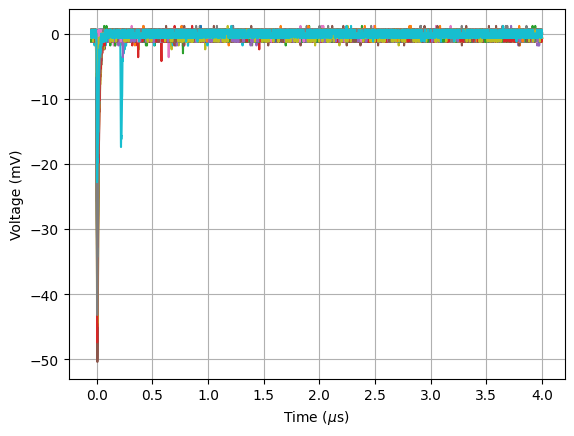

In [55]:
fig, ax = plt.subplots()
plot_waveforms(electron_dfs[:100], ax)
plt.show()

DELAY_TIMEより前のときのプロット（ミューオン）

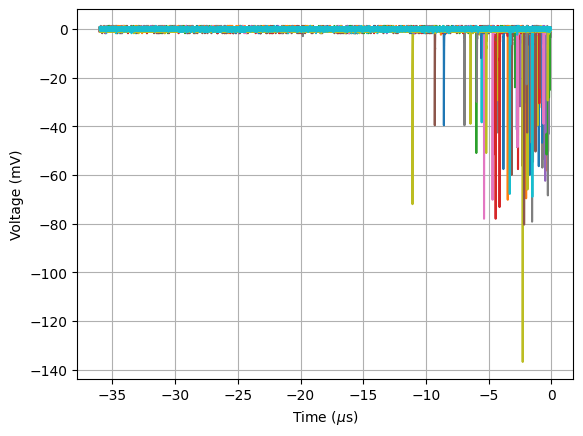

In [56]:
fig, ax = plt.subplots()
plot_waveforms(muon_dfs[:100], ax)
plt.show()

電圧が最小値周辺の領域の取得

In [57]:
# 1つの波形を取り出すための範囲
WIDTH = 200

In [58]:
# 最小
def getMinDataframe(df: pl.DataFrame, is_electron: bool):
    if is_electron: # 電子の信号
        minIndex = 0
    else:
        minIndex = df["CH1"].arg_min()
        if minIndex == None:
            print("No minimum value")
            print(df)
            return None
    length = df.shape[0]
    minRange = [minIndex-WIDTH, minIndex+WIDTH]
    if minRange[0] < 0:
        minRange[0] = 0
    if minRange[1] > length:
        minRange[1] = length
    return df[minRange[0]:minRange[1]]

In [59]:
min_muon_dfs = []
min_electron_dfs = []

for i in range(fastframe_count):
    min_muon_dfs.append(getMinDataframe(muon_dfs[i], is_electron=False))
    min_electron_dfs.append(getMinDataframe(electron_dfs[i], is_electron=True))

In [60]:
min_muon_dfs[7]

TIME,CH1
f64,f64
-4.7728e-7,-0.0006
-4.7648e-7,-0.0006
-4.7568e-7,0.0
-4.7488e-7,-0.0006
-4.7408e-7,0.0
…,…
-1.6128e-7,-0.0006
-1.6048e-7,0.0
-1.5968e-7,0.0


In [61]:
muon_dfs[7]

TIME,CH1
f64,f64
-0.000036,-0.0006
-0.000036,-0.0006
-0.000036,0.0
-0.000036,-0.0012
-0.000036,-0.0006
…,…
-5.4080e-8,0.0
-5.3280e-8,-0.0006
-5.2480e-8,0.0


In [62]:
def plot_waveform(df, ax):
    ax.plot(df["TIME"]*10**6, df["CH1"]*10**3)
    ax.set_xlabel(r"Time ($\mu $s)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()

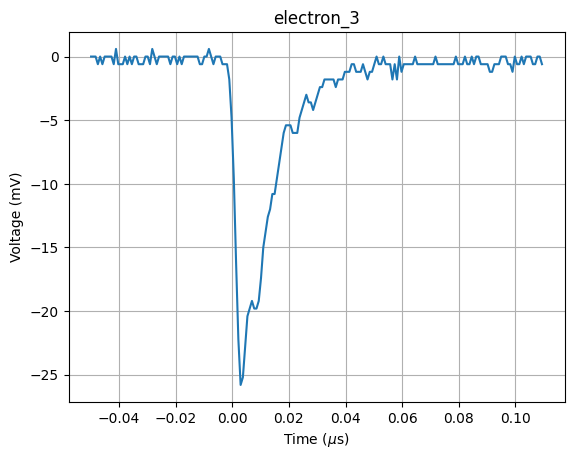

In [63]:
num = 3

fig, ax = plt.subplots()
plot_waveform(min_electron_dfs[num], ax)
ax.set_title("electron_{}".format(num))
fig.savefig(f"{IMAGE_PATH}/electron_{num}.png")
plt.show()

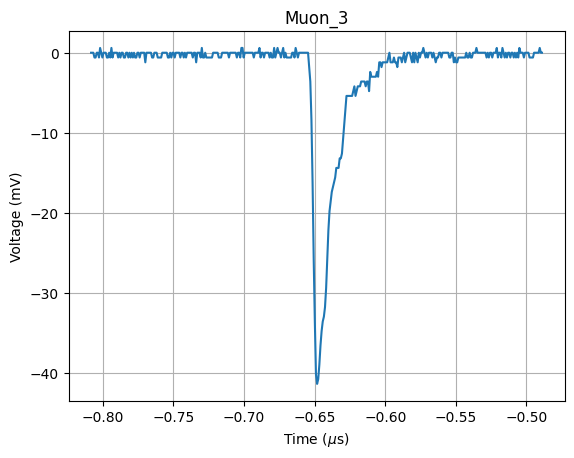

In [64]:
fig, ax = plt.subplots()
plot_waveform(min_muon_dfs[num], ax)
ax.set_title("Muon_{}".format(num))
fig.savefig(f"{IMAGE_PATH}/muon_{num}.png")
plt.show()

ある関数でフィッテング

In [65]:
def fitfunc(t, A, B, C, T):
    t = np.array(t)
    return np.where(t < T, C, -A*np.exp(-B*(t-T))+C)

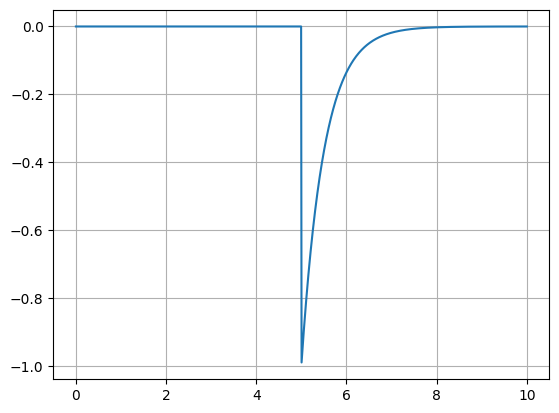

In [66]:
# 関数の確認
x = np.linspace(0, 10, 1000)
y = fitfunc(x, 1, 2, 0, 5)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
plt.show()

In [67]:
muon_dfs[1]["TIME"].to_numpy()

array([-3.599984e-05, -3.599904e-05, -3.599824e-05, ..., -5.184000e-08,
       -5.104000e-08, -5.024000e-08])

In [68]:
def fiting(df: pl.DataFrame, f, is_electron: bool):
    maxfev = 1000000  # 最大反復回数を増やす
    time = df["TIME"].to_numpy()
    ch1 = df["CH1"].to_numpy()
    
    # NaNとinfを削除
    mask = ~np.isnan(time) & ~np.isnan(ch1) & ~np.isinf(time) & ~np.isinf(ch1)
    time = time[mask]
    ch1 = ch1[mask]
    
    # 初期パラメータの調整
    A_init = ch1.min()
    C_init = 0
    if is_electron:
        B_init = 6e7 # ここの値は微調整が必要
        T_init = 0
    else:
        B_init = 1e8 # ここの値は微調整が必要   
        T_init = time[ch1.argmin()]
    init = [A_init, B_init, C_init, T_init]
    
    bounds = ([-1, 0, -1, time.min()], [np.inf, np.inf, 1, time.max()])
    
    try:
        popt, pcov = curve_fit(f, time, ch1, p0=init, bounds=bounds, maxfev=maxfev)
    except RuntimeError as e:
        print(f"Fit did not converge: {e}")
    return popt, pcov, mask

ミューオンのフィッティング

In [69]:
muon_popts = []
muon_pcovs = []
muon_masks = []

for i in range(fastframe_count):
    popt, pcov, mask = fiting(min_muon_dfs[i], fitfunc, is_electron=False)
    muon_popts.append(popt)
    muon_pcovs.append(pcov)
    muon_masks.append(mask)
muon_popts

[array([ 7.85908697e-02,  7.43481214e+07, -5.58452131e-04, -1.73575146e-06]),
 array([ 3.84478101e-02,  6.53486334e+07, -1.42766322e-04, -1.33422360e-06]),
 array([ 4.30395029e-02,  7.56676219e+07, -7.13829604e-05, -5.56148610e-07]),
 array([ 4.89778757e-02,  7.31016797e+07, -2.53028992e-04, -6.51185223e-07]),
 array([ 4.06379161e-02,  6.26443061e+07, -2.14751891e-04, -7.25484212e-07]),
 array([ 7.05527853e-02,  6.84799344e+07, -9.04800815e-04, -3.16427506e-06]),
 array([ 3.61274054e-02,  6.77826811e+07, -4.46026148e-04, -3.02551809e-07]),
 array([ 2.60557782e-02,  7.53119672e+07, -4.06657576e-04, -3.20215736e-07]),
 array([ 6.04270625e-02,  7.00516861e+07, -4.67094092e-04, -7.49365375e-07]),
 array([ 3.85086494e-02,  6.43905542e+07, -4.45800782e-04, -6.15206901e-07]),
 array([ 6.33162877e-02,  7.50069826e+07, -3.21156543e-04, -1.00639621e-06]),
 array([ 3.62420729e-02,  7.90825507e+07, -3.92748804e-04, -1.45987396e-06]),
 array([ 4.20493551e-02,  6.78659194e+07, -1.40237585e-04, -5.87

電子のフィッテング

In [70]:
electron_popts = []
electron_pcovs = []
electron_masks = []

for i in range(fastframe_count):
    popt, pcov, mask = fiting(min_electron_dfs[i], fitfunc, is_electron=True)
    electron_popts.append(popt)
    electron_pcovs.append(pcov)
    electron_masks.append(mask)
electron_popts

[array([ 2.34901265e-02,  6.86605112e+07, -2.11470125e-04,  5.36371639e-10]),
 array([ 3.40951548e-02,  8.60069837e+07, -7.43094510e-04,  1.47305090e-09]),
 array([ 2.97502165e-02,  7.34148881e+07, -2.60558275e-04,  2.30825912e-10]),
 array([ 2.38459260e-02,  7.12784125e+07, -4.71043832e-04,  2.02786450e-10]),
 array([ 6.65214048e-03,  3.88285148e+08, -5.74259009e-05, -8.45333240e-10]),
 array([ 5.20080601e-02,  6.55094044e+07, -1.05970755e-03,  1.87731794e-09]),
 array([ 5.26297339e-03,  1.27589098e+08, -4.17393006e-04, -2.50835429e-09]),
 array([ 7.86002748e-03,  6.67579743e+07, -3.16125872e-04, -1.62700985e-09]),
 array([ 4.25811563e-02,  8.42672259e+07, -1.28348700e-03,  5.03255443e-09]),
 array([ 3.29197514e-03,  1.27504162e+08, -4.65154762e-04, -2.59493794e-09]),
 array([ 3.13516340e-02,  6.96758537e+07, -5.95073110e-04,  1.69573810e-09]),
 array([ 4.84028420e-02,  6.90405029e+07, -5.40879615e-04,  1.63280438e-09]),
 array([ 3.04707792e-02,  6.23638291e+07, -2.20085305e-04,  1.52

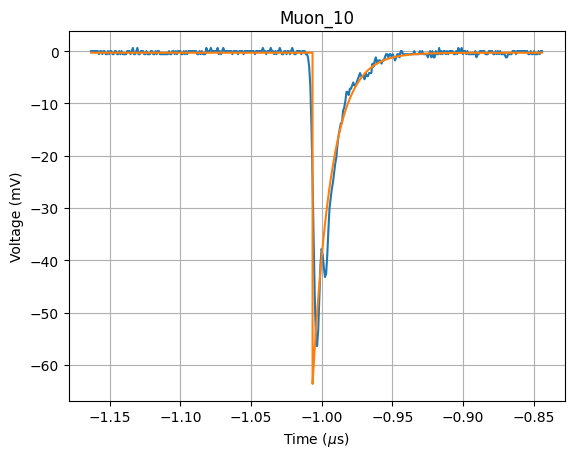

In [71]:
# ミューオンのフィッテング結果
num = 10
plus_x = 0 # 1e-8 # 範囲指定

fig, ax = plt.subplots()
x = np.linspace(min_muon_dfs[num]["TIME"].min(), min_muon_dfs[num]["TIME"].max()+plus_x, 10000)
plot_waveform(min_muon_dfs[num], ax)
ax.plot(x*10**6, fitfunc(x, *muon_popts[num])*10**3)
ax.set_title("Muon_{}".format(num))
fig.savefig(f"{IMAGE_PATH}/muon_fit_{num}.png")
plt.show()

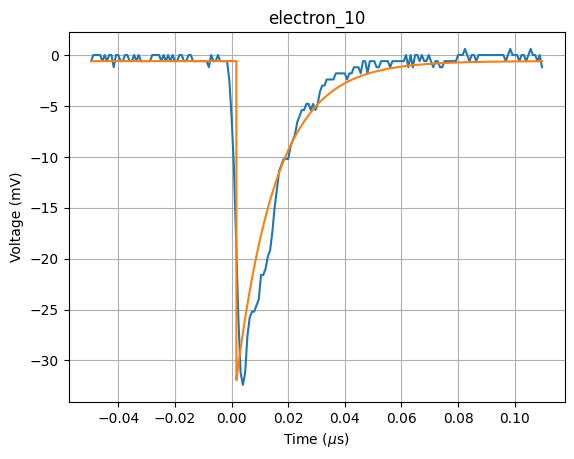

In [72]:
# 電子のフィッテング結果
fig, ax = plt.subplots()
x = np.linspace(min_electron_dfs[num]["TIME"].min(), min_electron_dfs[num]["TIME"].max()+plus_x, 10000)
plot_waveform(min_electron_dfs[num], ax)
ax.plot(x*10**6, fitfunc(x, *electron_popts[num])*10**3)
ax.set_title("electron_{}".format(num))
fig.savefig(f"{IMAGE_PATH}/electron_fit_{num}.png")
plt.show()

ミューオンの寿命

In [73]:
def get_deltaT(muon_popts, electron_popts):
    deltaT = []
    for i in range(fastframe_count):
        electronT = electron_popts[i][3]
        muonT = muon_popts[i][3]
        deltaT.append(electronT - muonT)
    return deltaT

In [74]:
bin_num = 60

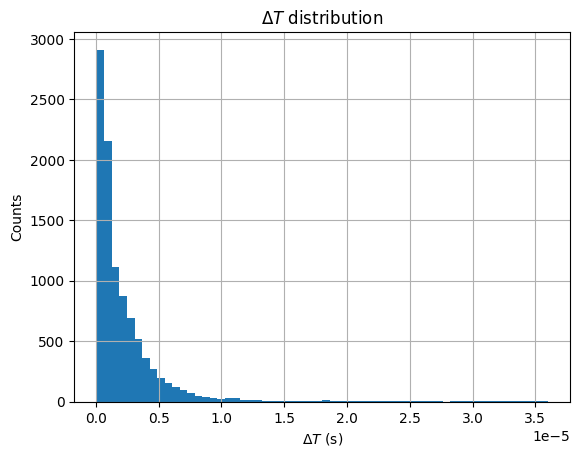

In [75]:
fig, ax = plt.subplots()
deltaT = get_deltaT(muon_popts, electron_popts)
ax.hist(deltaT, bins=bin_num)
ax.set_xlabel(r"$\Delta T$ (s)")
ax.set_ylabel("Counts")
ax.grid()
ax.set_title(r"$\Delta T$ distribution")
plt.show()

バックグラウンドの除去せずにミューオンの寿命の測定

In [76]:
def getBinCount(deltaT, bin_num):
    max_deltaT = max(deltaT)
    bin_width = np.arange(0, max_deltaT, max_deltaT/bin_num)
    count, time = np.histogram(deltaT, bins=bin_width)
    centerTime = (time[:-1] + time[1:]) / 2
    return count, centerTime

In [77]:
deltaT_count, deltaT_time = getBinCount(deltaT, bin_num)


# 0の値を削除
mask = np.where(deltaT_count == 0, False, True)
mask
deltaT_count = deltaT_count[mask]
deltaT_time = deltaT_time[mask]

# deltaTがある値以上のものを削除(非推奨)
limT = 0.8e-5
mask = np.where(deltaT_time > limT, False, True)
deltaT_count = deltaT_count[mask]
deltaT_time = deltaT_time[mask]

# 対数をとることで線形に
log_deltaT_count = np.log(deltaT_count)

model = LinearRegression()
model.fit(deltaT_time.reshape(-1, 1), log_deltaT_count)
a = model.coef_[0]
b = model.intercept_

tau = -1/a
N_0 = np.exp(b)

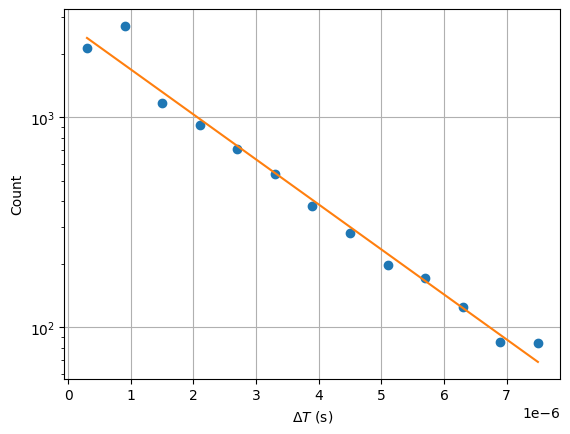

In [78]:
fig, ax = plt.subplots()
ax.plot(deltaT_time, deltaT_count, "o")
ax.plot(deltaT_time, N_0*np.exp(a*deltaT_time))
ax.set_yscale("log")
ax.set_xlabel(r"$\Delta T$ (s)")
ax.set_ylabel("Count")
ax.grid()

In [79]:
print(rf"tau: {float(tau)*1e6:.2f} us")

tau: 2.02 us


面積(総電荷量)の測定

In [80]:
def S(popt):
    A, B, _, _ = popt
    return A/B

def integrate_min_dfs(min_dfs: list):
    integrals = []
    for df in min_dfs:
        if df is not None:
            time = df['TIME'].to_numpy()
            ch1 = -df['CH1'].to_numpy()
            integral = np.trapz(ch1, time)
            integrals.append(integral)
    return integrals

フィッティングのS

In [81]:
muon_S = []
electron_S = []
for i in range(fastframe_count):
    muon_S.append(S(muon_popts[i]))
    electron_S.append(S(electron_popts[i]))
muon_S

[np.float64(1.0570659788120514e-09),
 np.float64(5.88349107369719e-10),
 np.float64(5.687968220996335e-10),
 np.float64(6.699965846259041e-10),
 np.float64(6.487088548941668e-10),
 np.float64(1.0302694638999505e-09),
 np.float64(5.329887344433326e-10),
 np.float64(3.4597128652454265e-10),
 np.float64(8.626068247936367e-10),
 np.float64(5.980481133926649e-10),
 np.float64(8.441385787900578e-10),
 np.float64(4.582815374725748e-10),
 np.float64(6.195945695976933e-10),
 np.float64(1.2951353845989352e-09),
 np.float64(6.240967720454835e-10),
 np.float64(9.020504529847065e-10),
 np.float64(1.2978194071026167e-09),
 np.float64(1.0842880042864871e-09),
 np.float64(1.205781946631471e-09),
 np.float64(5.07650542404864e-10),
 np.float64(7.046855067567838e-10),
 np.float64(9.796134379549344e-10),
 np.float64(4.135675537437095e-10),
 np.float64(8.606415591274617e-10),
 np.float64(4.6314331665184204e-10),
 np.float64(1.0143932921954658e-09),
 np.float64(6.593894441617442e-10),
 np.float64(6.64251568

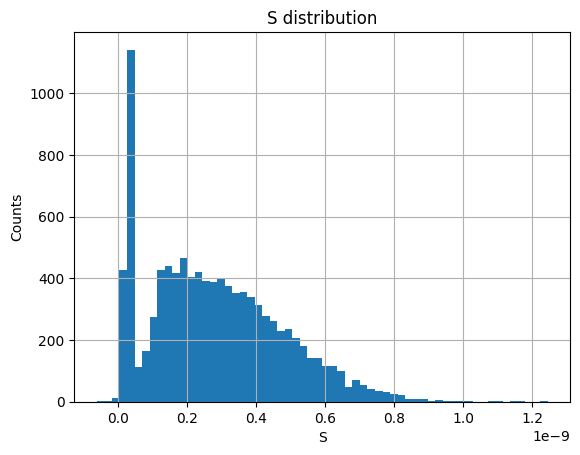

In [82]:
fig, ax = plt.subplots()
ax.hist(electron_S, bins=bin_num, label="electron")
ax.set_xlabel("S")
ax.set_ylabel("Counts")
ax.grid()
ax.set_title("S distribution")
plt.show()

積分値のS

In [83]:
int_electron = integrate_min_dfs(min_electron_dfs)

/tmp/ipykernel_46460/791834965.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(ch1, time)


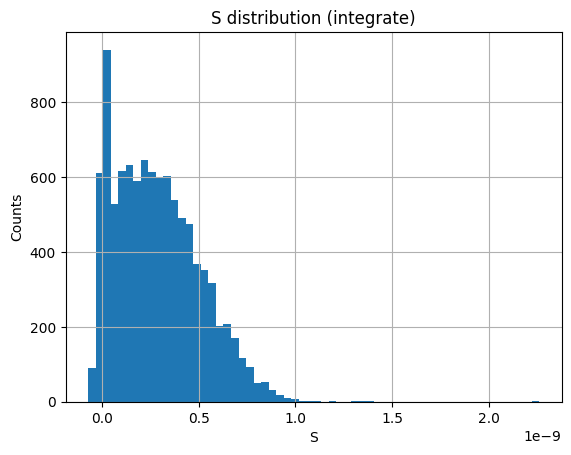

In [84]:
fig, ax = plt.subplots()
ax.hist(int_electron, bins=bin_num, label="electron")
ax.set_xlabel("S")
ax.set_ylabel("Counts")
ax.grid()
ax.set_title("S distribution (integrate)")
plt.show()

フィッテング結果をCSVとして保存

In [88]:
electron_T = [electron_popts[i][3] for i in range(fastframe_count)]
muon_T = [muon_popts[i][3] for i in range(fastframe_count)]
IT_df = pl.DataFrame({
    "Electron_T": electron_T,
    "Electron_S": electron_S,
    "Muon_T": muon_T,
    "Muon_S": muon_S,
})

In [89]:
IT_df

Electron_T,Electron_S,Muon_T,Muon_S
f64,f64,f64,f64
5.3637e-10,3.4212e-10,-0.000002,1.0571e-9
1.4731e-9,3.9642e-10,-0.000001,5.8835e-10
2.3083e-10,4.0523e-10,-5.5615e-7,5.6880e-10
2.0279e-10,3.3455e-10,-6.5119e-7,6.7000e-10
-8.4533e-10,1.7132e-11,-7.2548e-7,6.4871e-10
…,…,…,…
1.3198e-9,4.5070e-10,-1.1716e-7,7.9816e-10
-3.6488e-9,4.0802e-11,-3.0206e-7,2.0269e-10
-1.8998e-11,3.4658e-10,-3.7568e-7,8.1418e-10


In [90]:
IT_df.write_csv(f"{IT_PATH}/IT.csv")